In [1]:
import pandas as pd # Used to open CSV files 
import numpy as np # Used for matrix operations
import cv2 # Used for image augmentation
from matplotlib import pyplot as plt
np.random.seed(666)


from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
df_train = pd.read_json('data/train.json')

In [3]:
def get_scaled_imgs(df):
    imgs = []
    
    for i, row in df.iterrows():
        #make 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)
        
        # Rescale
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

        imgs.append(np.dstack((a, b, c)))

    return np.array(imgs)

In [4]:
Xtrain = get_scaled_imgs(df_train)
Ytrain = np.array(df_train['is_iceberg'])


df_train.inc_angle = df_train.inc_angle.replace('na',0)
idx_tr = np.where(df_train.inc_angle>0)


Ytrain = Ytrain[idx_tr[0]]
Xtrain = Xtrain[idx_tr[0],...]

In [5]:
def get_more_images(imgs):
    
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        ch=cv2.flip(c,0)
        
        vert_flip_imgs.append(np.dstack((av, bv, cv)))
        hori_flip_imgs.append(np.dstack((ah, bh, ch)))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h))
    
    return more_images


In [6]:
Xtr_more = get_more_images(Xtrain) 
Ytr_more = np.concatenate((Ytrain,Ytrain,Ytrain))

In [7]:
def get_more_images(imgs):
    
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        ch=cv2.flip(c,0)
        
        vert_flip_imgs.append(np.dstack((av, bv, cv)))
        hori_flip_imgs.append(np.dstack((ah, bh, ch)))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h))
    
    return more_images


In [8]:
Ytr_more = np.concatenate((Ytrain,Ytrain,Ytrain))

In [9]:
def getModel():
    #Build keras model
    
    model=Sequential()
    
    # CNN 1
    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 2
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.3))

    #CNN 4
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.3))

    # You must flatten the data for the dense layers
    model.add(Flatten())

    #Dense 1
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    #Dense 2
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    # Output 
    model.add(Dense(1, activation="sigmoid"))

    optimizer = Adam(lr=0.001, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [10]:
model = getModel()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
__________

Train on 3309 samples, validate on 1104 samples
Epoch 1/50
3309/3309 [==============================] - 2s 599us/step - loss: 0.0709 - acc: 0.9734 - val_loss: 0.2393 - val_acc: 0.9230
Epoch 2/50
3309/3309 [==============================] - 2s 594us/step - loss: 0.0636 - acc: 0.9743 - val_loss: 0.2353 - val_acc: 0.9203
Epoch 3/50
3309/3309 [==============================] - 2s 591us/step - loss: 0.0651 - acc: 0.9779 - val_loss: 0.2290 - val_acc: 0.9239
Epoch 4/50
3309/3309 [==============================] - 2s 572us/step - loss: 0.0659 - acc: 0.9770 - val_loss: 0.2342 - val_acc: 0.9221
Epoch 5/50
3309/3309 [==============================] - 2s 570us/step - loss: 0.0674 - acc: 0.9737 - val_loss: 0.2457 - val_acc: 0.9212
Epoch 6/50
3309/3309 [==============================] - 2s 571us/step - loss: 0.0598 - acc: 0.9776 - val_loss: 0.2545 - val_acc: 0.9212
Epoch 7/50
3309/3309 [==============================] - 2s 573us/step - loss: 0.0537 - acc: 0.9788 - val_loss: 0.2508 - val_acc: 0.9239


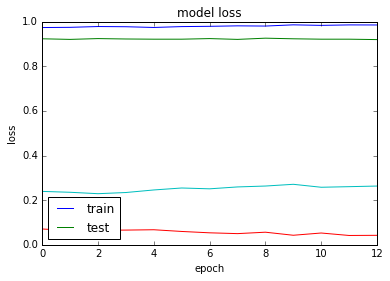

In [12]:
%matplotlib inline
batch_size = 32
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
#-------------------------------------------------------------------------------------------------------------------
# Let's view progress 
history = model.fit(Xtr_more, Ytr_more, batch_size=batch_size, epochs=50, verbose=1, 
                    callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.25)

print(history.history.keys())
#
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
#
fig.savefig('performance.png')
#---------------------------------------------------------------------------------------


In [14]:
model.load_weights(filepath = '.mdl_wts.hdf5')

score = model.evaluate(Xtrain, Ytrain, verbose=1)
print('Train score:', score[0])
print('Train accuracy:', score[1])

df_test = pd.read_json('data/test.json')
df_test.inc_angle = df_test.inc_angle.replace('na',0)
Xtest = (get_scaled_imgs(df_test))
pred_test = model.predict(Xtest)

submission = pd.DataFrame({'id': df_test["id"], 'is_iceberg': pred_test.reshape((pred_test.shape[0]))})
print(submission.head(10))

submission.to_csv('subv2.csv', index=False)

1471/1471 [==============================] - 0s 198us/step
Train score: 0.031374764711
Train accuracy: 0.99184228416
         id    is_iceberg
0  5941774d  4.646234e-05
1  4023181e  9.976820e-01
2  b20200e4  5.886349e-04
3  e7f018bb  9.999979e-01
4  4371c8c3  9.943563e-01
5  a8d9b1fd  1.811555e-01
6  29e7727e  4.263509e-03
7  92a51ffb  9.999707e-01
8  c769ac97  1.132313e-07
9  aee0547d  2.296392e-06
